<a href="https://colab.research.google.com/github/samsaak/EvoloPy-NN/blob/master/AdaptiveMetaheuristics_2_Grok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Define the test function
def fitness(x):
    """Calculate the sum of squares fitness function."""
    return np.sum(x**2)

In [ ]:
# Genetic Algorithm Class
class GA:
    def __init__(self, lb, ub, dim, pop_size=50, crossover_rate=0.8, mutation_rate=0.1):
        """Initialize GA with population and parameters."""
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = np.random.uniform(lb, ub, (pop_size, dim))
        self.fitness = np.array([fitness(ind) for ind in self.population])

    def step(self, iter, total_iter):
        """Perform one GA iteration: selection, crossover, mutation."""
        # Tournament selection
        tournament_size = 3
        parents = []
        for _ in range(self.pop_size):
            candidates = np.random.choice(self.pop_size, tournament_size, replace=False)
            best_candidate = candidates[np.argmin(self.fitness[candidates])]
            parents.append(self.population[best_candidate])
        parents = np.array(parents)

        # Crossover
        offspring = []
        for i in range(0, self.pop_size, 2):
            parent1 = parents[i]
            parent2 = parents[i+1] if i+1 < self.pop_size else parents[0]
            if np.random.rand() < self.crossover_rate:
                cp = np.random.randint(1, self.dim)  # One-point crossover
                child1 = np.concatenate((parent1[:cp], parent2[cp:]))
                child2 = np.concatenate((parent2[:cp], parent1[cp:]))
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            offspring.extend([child1, child2])
        offspring = offspring[:self.pop_size]

        # Mutation
        for ind in offspring:
            if np.random.rand() < self.mutation_rate:
                mutation_idx = np.random.randint(0, self.dim)
                ind[mutation_idx] += np.random.normal(0, 1)
                ind = np.clip(ind, self.lb, self.ub)

        # Evaluate and update population
        self.fitness = np.array([fitness(ind) for ind in offspring])
        self.population = np.array(offspring)
        return self.population[np.argmin(self.fitness)]  # Best offspring

    def get_best_solution(self):
        """Return the best solution in the current population."""
        return self.population[np.argmin(self.fitness)]

In [ ]:
# Particle Swarm Optimization Class
class PSO:
    def __init__(self, lb, ub, dim, swarm_size=50, w=0.5, c1=1.5, c2=1.5):
        """Initialize PSO with swarm and parameters."""
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.swarm_size = swarm_size
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.positions = np.random.uniform(lb, ub, (swarm_size, dim))
        self.velocities = np.random.uniform(-1, 1, (swarm_size, dim))
        self.pbest_positions = self.positions.copy()
        self.pbest_fitness = np.array([fitness(p) for p in self.positions])
        self.gbest_idx = np.argmin(self.pbest_fitness)
        self.gbest_position = self.pbest_positions[self.gbest_idx].copy()

    def step(self, iter, total_iter):
        """Perform one PSO iteration: update velocities and positions."""
        for i in range(self.swarm_size):
            r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim)
            self.velocities[i] = (self.w * self.velocities[i] +
                                  self.c1 * r1 * (self.pbest_positions[i] - self.positions[i]) +
                                  self.c2 * r2 * (self.gbest_position - self.positions[i]))
            self.positions[i] += self.velocities[i]
            self.positions[i] = np.clip(self.positions[i], self.lb, self.ub)
            new_fitness = fitness(self.positions[i])
            if new_fitness < self.pbest_fitness[i]:
                self.pbest_positions[i] = self.positions[i].copy()
                self.pbest_fitness[i] = new_fitness
                if new_fitness < self.pbest_fitness[self.gbest_idx]:
                    self.gbest_idx = i
                    self.gbest_position = self.positions[i].copy()
        return self.gbest_position  # Best solution after update

    def get_best_solution(self):
        """Return the global best solution."""
        return self.gbest_position


In [ ]:
# Grey Wolf Optimizer Class
class GWO:
    def __init__(self, lb, ub, dim, pack_size=50):
        """Initialize GWO with wolf pack and parameters."""
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.pack_size = pack_size
        self.positions = np.random.uniform(lb, ub, (pack_size, dim))
        self.fitness = np.array([fitness(p) for p in self.positions])
        sorted_indices = np.argsort(self.fitness)
        self.alpha_idx = sorted_indices[0]
        self.beta_idx = sorted_indices[1]
        self.delta_idx = sorted_indices[2]

    def step(self, iter, total_iter):
        """Perform one GWO iteration: update positions based on alpha, beta, delta."""
        a = 2 - 2 * (iter / total_iter)  # Linearly decrease a from 2 to 0
        for i in range(self.pack_size):
            A1 = 2 * a * np.random.rand(self.dim) - a
            C1 = 2 * np.random.rand(self.dim)
            D_alpha = np.abs(C1 * self.positions[self.alpha_idx] - self.positions[i])
            X1 = self.positions[self.alpha_idx] - A1 * D_alpha

            A2 = 2 * a * np.random.rand(self.dim) - a
            C2 = 2 * np.random.rand(self.dim)
            D_beta = np.abs(C2 * self.positions[self.beta_idx] - self.positions[i])
            X2 = self.positions[self.beta_idx] - A2 * D_beta

            A3 = 2 * a * np.random.rand(self.dim) - a
            C3 = 2 * np.random.rand(self.dim)
            D_delta = np.abs(C3 * self.positions[self.delta_idx] - self.positions[i])
            X3 = self.positions[self.delta_idx] - A3 * D_delta

            self.positions[i] = (X1 + X2 + X3) / 3
            self.positions[i] = np.clip(self.positions[i], self.lb, self.ub)
            self.fitness[i] = fitness(self.positions[i])

        sorted_indices = np.argsort(self.fitness)
        self.alpha_idx = sorted_indices[0]
        self.beta_idx = sorted_indices[1]
        self.delta_idx = sorted_indices[2]
        return self.positions[self.alpha_idx]  # Alpha’s position

    def get_best_solution(self):
        """Return the alpha wolf’s position (best solution)."""
        return self.positions[self.alpha_idx]

In [ ]:
# Continuous Ant Colony Optimization Class
class ContinuousACO:
    def __init__(self, lb, ub, dim, num_ants=10, archive_size=10, sigma=1.0):
        """Initialize ACO with archive for continuous optimization."""
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.num_ants = num_ants
        self.archive_size = archive_size
        self.sigma = sigma
        self.archive = [np.random.uniform(lb, ub, dim) for _ in range(archive_size)]
        self.archive_fitness = [fitness(sol) for sol in self.archive]
        self.archive, self.archive_fitness = zip(*sorted(zip(self.archive, self.archive_fitness), key=lambda x: x[1]))
        self.archive = list(self.archive)
        self.archive_fitness = list(self.archive_fitness)

    def step(self, iter, total_iter):
        """Perform one ACO iteration: ants build solutions from archive."""
        ranks = np.arange(1, self.archive_size + 1)
        weights = 1 / (ranks * self.archive_size)  # Weight inversely proportional to rank
        weights /= np.sum(weights)  # Normalize
        ant_solutions = []
        for _ in range(self.num_ants):
            solution = np.zeros(self.dim)
            for d in range(self.dim):
                s = np.random.choice(self.archive_size, p=weights)
                solution[d] = np.random.normal(self.archive[s][d], self.sigma)
            solution = np.clip(solution, self.lb, self.ub)
            ant_solutions.append(solution)
        ant_fitness = [fitness(sol) for sol in ant_solutions]
        best_ant_idx = np.argmin(ant_fitness)
        best_ant_solution = ant_solutions[best_ant_idx]
        best_ant_fitness = ant_fitness[best_ant_idx]
        if best_ant_fitness < self.archive_fitness[-1]:
            self.archive.append(best_ant_solution)
            self.archive_fitness.append(best_ant_fitness)
            if len(self.archive) > self.archive_size:
                worst_idx = np.argmax(self.archive_fitness)
                del self.archive[worst_idx]
                del self.archive_fitness[worst_idx]
            self.archive, self.archive_fitness = zip(*sorted(zip(self.archive, self.archive_fitness), key=lambda x: x[1]))
            self.archive = list(self.archive)
            self.archive_fitness = list(self.archive_fitness)
        return best_ant_solution  # Best ant solution

    def get_best_solution(self):
        """Return the best solution in the archive."""
        return self.archive[0]

In [ ]:
# Main Hybrid Framework
def main():
    """Run the hybrid adaptive optimization framework."""
    lb, ub, dim = -100, 100, 30
    total_iterations = 1000
    switch_iter = 100  # Switch to weighted selection after 100 iterations
    num_runs = 10
    results = []

    for run_id in range(num_runs):
        np.random.seed(run_id)  # Ensure reproducibility
        # Initialize algorithms
        ga = GA(lb, ub, dim)
        pso = PSO(lb, ub, dim)
        gwo = GWO(lb, ub, dim)
        aco = ContinuousACO(lb, ub, dim)
        algorithms = [ga, pso, gwo, aco]

        # Set initial global best
        initial_fitnesses = [fitness(alg.get_best_solution()) for alg in algorithms]
        min_fitness_idx = np.argmin(initial_fitnesses)
        global_best = algorithms[min_fitness_idx].get_best_solution().copy()
        global_best_fitness = initial_fitnesses[min_fitness_idx]

        # Initialize weights and tracking
        weights = [1.0] * len(algorithms)
        selection_counts = [0] * len(algorithms)
        selection_history = [list(selection_counts)]
        convergence = [global_best_fitness]

        # Optimization loop
        for iter in range(total_iterations):
            # Select algorithm
            if iter < switch_iter:
                alg_idx = np.random.randint(0, len(algorithms))  # Random selection
            else:
                prob = [w / sum(weights) for w in weights]  # Weighted selection
                alg_idx = np.random.choice(len(algorithms), p=prob)
            alg = algorithms[alg_idx]
            selection_counts[alg_idx] += 1

            # Perform step and update global best
            new_solution = alg.step(iter, total_iterations)
            new_fitness = fitness(new_solution)
            if new_fitness < global_best_fitness:
                global_best = new_solution.copy()
                global_best_fitness = new_fitness
                weights[alg_idx] += 0.1  # Increase weight for improvement
                total_weight = sum(weights)
                weights = [w / total_weight for w in weights]  # Normalize

            # Record progress
            selection_history.append(list(selection_counts))
            convergence.append(global_best_fitness)

        results.append({
            'run_id': run_id,
            'final_fitness': global_best_fitness,
            'convergence': convergence,
            'selection_history': selection_history
        })

    # Process results
    best_run = min(results, key=lambda x: x['final_fitness'])
    all_final_fitness = [r['final_fitness'] for r in results]
    best_final, worst_final = min(all_final_fitness), max(all_final_fitness)

    # Save to Excel
    df_convergence = pd.DataFrame({
        'Iteration': range(total_iterations + 1),
        'Global_Best_Fitness': best_run['convergence'],
        'Selection_GA': [h[0] for h in best_run['selection_history']],
        'Selection_PSO': [h[1] for h in best_run['selection_history']],
        'Selection_GWO': [h[2] for h in best_run['selection_history']],
        'Selection_ACO': [h[3] for h in best_run['selection_history']]
    })
    df_summary = pd.DataFrame({
        'Best_Final_Fitness': [best_final],
        'Worst_Final_Fitness': [worst_final]
    })
    with pd.ExcelWriter('optimization_results.xlsx') as writer:
        df_convergence.to_excel(writer, sheet_name='Best_Run_Convergence', index=False)
        df_summary.to_excel(writer, sheet_name='Summary', index=False)

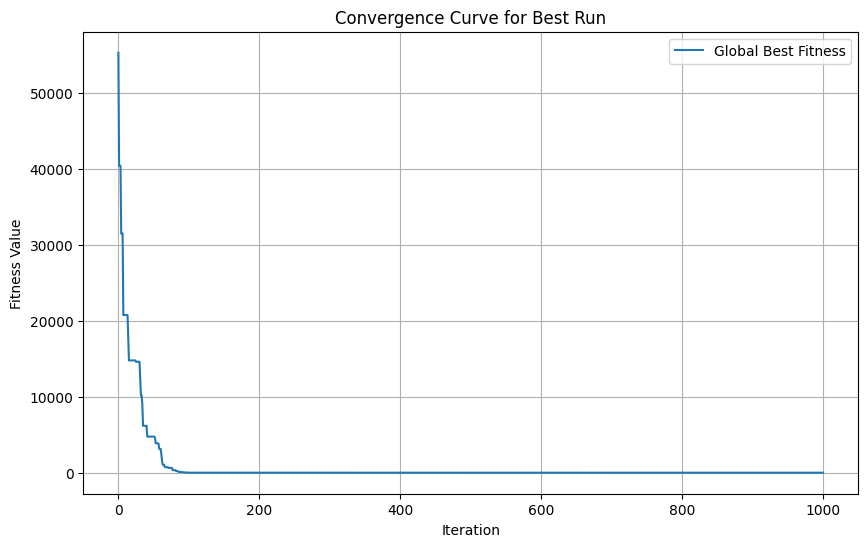

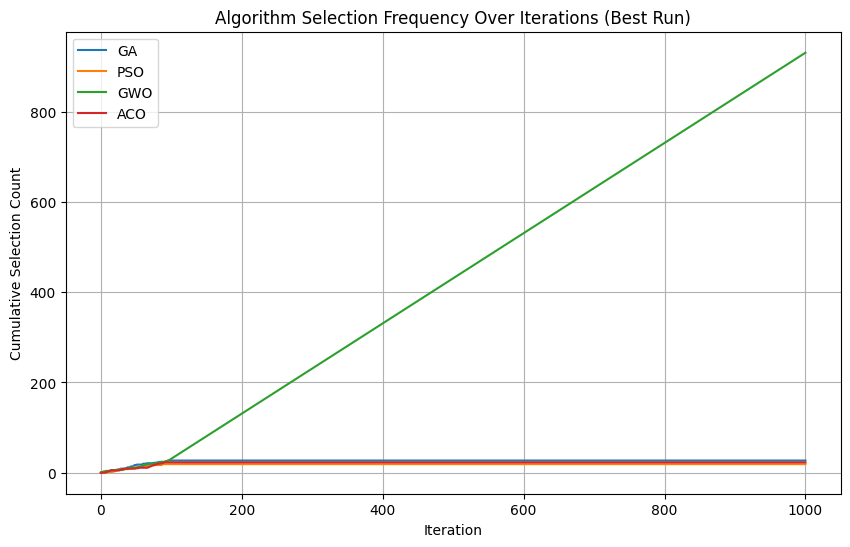

In [ ]:
# Main Hybrid Framework
def main():
    """Run the hybrid adaptive optimization framework."""
    lb, ub, dim       = -100, 100, 30
    total_iterations  = 1000
    switch_iter       = 100  # Switch to weighted selection after 100 iterations
    num_runs          = 10
    results           = []

    for run_id in range(num_runs):
        np.random.seed(run_id)  # Ensure reproducibility
        # Initialize algorithms
        ga  = GA(lb, ub, dim)
        pso = PSO(lb, ub, dim)
        gwo = GWO(lb, ub, dim)
        aco = ContinuousACO(lb, ub, dim)
        algorithms = [ga, pso, gwo, aco]

        # Set initial global best
        initial_fitnesses   = [fitness(alg.get_best_solution()) for alg in algorithms]
        min_fitness_idx     = np.argmin(initial_fitnesses)
        global_best         = algorithms[min_fitness_idx].get_best_solution().copy()
        global_best_fitness = initial_fitnesses[min_fitness_idx]

        # Initialize weights and tracking
        weights = [1.0] * len(algorithms)
        selection_counts = [0] * len(algorithms)
        selection_history = [list(selection_counts)]
        convergence = [global_best_fitness]

        # Optimization loop
        for iter in range(total_iterations):
            # Select algorithm
            if iter < switch_iter:
                alg_idx = np.random.randint(0, len(algorithms))  # Random selection
            else:
                prob = [w / sum(weights) for w in weights]  # Weighted selection
                alg_idx = np.random.choice(len(algorithms), p=prob)
            alg = algorithms[alg_idx]
            selection_counts[alg_idx] += 1

            # Perform step and update global best
            new_solution = alg.step(iter, total_iterations)
            new_fitness = fitness(new_solution)
            if new_fitness < global_best_fitness:
                global_best = new_solution.copy()
                global_best_fitness = new_fitness
                weights[alg_idx] += 0.1  # Increase weight for improvement
                total_weight = sum(weights)
                weights = [w / total_weight for w in weights]  # Normalize

            # Record progress
            selection_history.append(list(selection_counts))
            convergence.append(global_best_fitness)

        results.append({
            'run_id': run_id,
            'final_fitness': global_best_fitness,
            'convergence': convergence,
            'selection_history': selection_history
        })

    # Process results
    best_run = min(results, key=lambda x: x['final_fitness'])
    all_final_fitness = [r['final_fitness'] for r in results]
    best_final, worst_final = min(all_final_fitness), max(all_final_fitness)

    # Save to Excel
    df_convergence = pd.DataFrame({
        'Iteration': range(total_iterations + 1),
        'Global_Best_Fitness': best_run['convergence'],
        'Selection_GA':  [h[0] for h in best_run['selection_history']],
        'Selection_PSO': [h[1] for h in best_run['selection_history']],
        'Selection_GWO': [h[2] for h in best_run['selection_history']],
        'Selection_ACO': [h[3] for h in best_run['selection_history']]
    })
    df_summary = pd.DataFrame({
        'Best_Final_Fitness': [best_final],
        'Worst_Final_Fitness': [worst_final]
    })
    with pd.ExcelWriter('optimization_results.xlsx') as writer:
        df_convergence.to_excel(writer, sheet_name='Best_Run_Convergence', index=False)
        df_summary.to_excel(writer, sheet_name='Summary', index=False)

    # Plot convergence curve
    plt.figure(figsize=(10, 6))
    plt.plot(df_convergence['Iteration'], df_convergence['Global_Best_Fitness'], label='Global Best Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.title('Convergence Curve for Best Run')
    plt.legend()
    plt.grid(True)
    plt.savefig('convergence_curve.png')
    plt.show()

    # Plot selection frequencies
    plt.figure(figsize=(10, 6))
    for alg in ['GA', 'PSO', 'GWO', 'ACO']:
        plt.plot(df_convergence['Iteration'], df_convergence[f'Selection_{alg}'], label=alg)
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Selection Count')
    plt.title('Algorithm Selection Frequency Over Iterations (Best Run)')
    plt.legend()
    plt.grid(True)
    plt.savefig('selection_frequency.png')
    plt.show()

if __name__ == '__main__':
    main()